# Optimized Race Line (ORL)

Track-based analysis, iterating over given plots to define an optimized race line.

Ref: [Capstone AWS DeepRacer](https://github.com/dgnzlz/Capstone_AWS_DeepRacer/)
Ref (Original): [cdthompson k1999-race-lines](https://github.com/cdthompson/deepracer-k1999-race-lines/)

In [43]:
import os.path
import copy
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

from shapely import LineString, Polygon, Point

## Setup

In [29]:
# Global declarations
TRACKS_DIR = "../resources/tracks"
RACE_LINES_DIR = "../resources/racelines"

TRACK_NAME = "2022_october_pro"

# Track-based parameters; change and recalculate as desired
opt_track_width_reduction_perc: float = 0.80  # as % of default width

In [30]:
# Setup Generics
class TrackDotDict(dict):
    def __getattr__(self, attr):
        return self.get(attr)
    
def get_available_tracks(base_dir: str = TRACKS_DIR) -> list:
    available_track_files = glob.glob(f"{base_dir}/**.npy")
    available_track_names = list(map(lambda x: os.path.basename(x).split('.npy')[0], available_track_files))
    return available_track_names

In [31]:
# Track Data
def get_track_data_by_arn(base_dir: str = TRACKS_DIR, filename: str = TRACK_NAME):
    with open(f"{base_dir}/tracks.json", "r") as track_json_file:
        for i in json.load(track_json_file):
            lower_arn: str = i.get('TrackArn', '').lower()
            if lower_arn.endswith(filename.lower()):
                return i
    return None

def get_default_waypoints(base_dir: str = TRACKS_DIR, filename: str = TRACK_NAME):
    return np.load(f"{base_dir}/{filename}.npy")

def get_reduced_waypoints(given_points, reduce_by: float = opt_track_width_reduction_perc):
    def dist_2_points(x1, x2, y1, y2):
        return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5
    def x_perc_width(waypoint, perc_width):
        center_x, center_y, inner_x, inner_y, outer_x, outer_y = waypoint
        width = dist_2_points(inner_x, outer_x, inner_y, outer_y)
        
        delta_x = outer_x-inner_x
        delta_y = outer_y-inner_y
    
        inner_x_new = inner_x + delta_x/2 * (1-perc_width)
        outer_x_new = outer_x - delta_x/2 * (1-perc_width)
        inner_y_new = inner_y + delta_y/2 * (1-perc_width)
        outer_y_new = outer_y - delta_y/2 * (1-perc_width)
    
        return [center_x, center_y, inner_x_new, inner_y_new, outer_x_new, outer_y_new]
    reduced_points = [x_perc_width(waypoint, perc_width=reduce_by) for waypoint in given_points]
    reduced_points_array = np.asarray(reduced_points)
    r_inner_border = reduced_points_array[:,2:4]
    r_outer_border = reduced_points_array[:,4:6]
    return r_inner_border, r_outer_border

In [32]:
# For ease of use...
__track_ctx = get_track_data_by_arn(filename=TRACK_NAME)

track = TrackDotDict({
    'name': TRACK_NAME,
    'width': __track_ctx.get('TrackWidth'),
    'length': __track_ctx.get('TrackLength')
})
print(track)

{'name': '2022_october_pro', 'width': 1.07, 'length': 62.08}


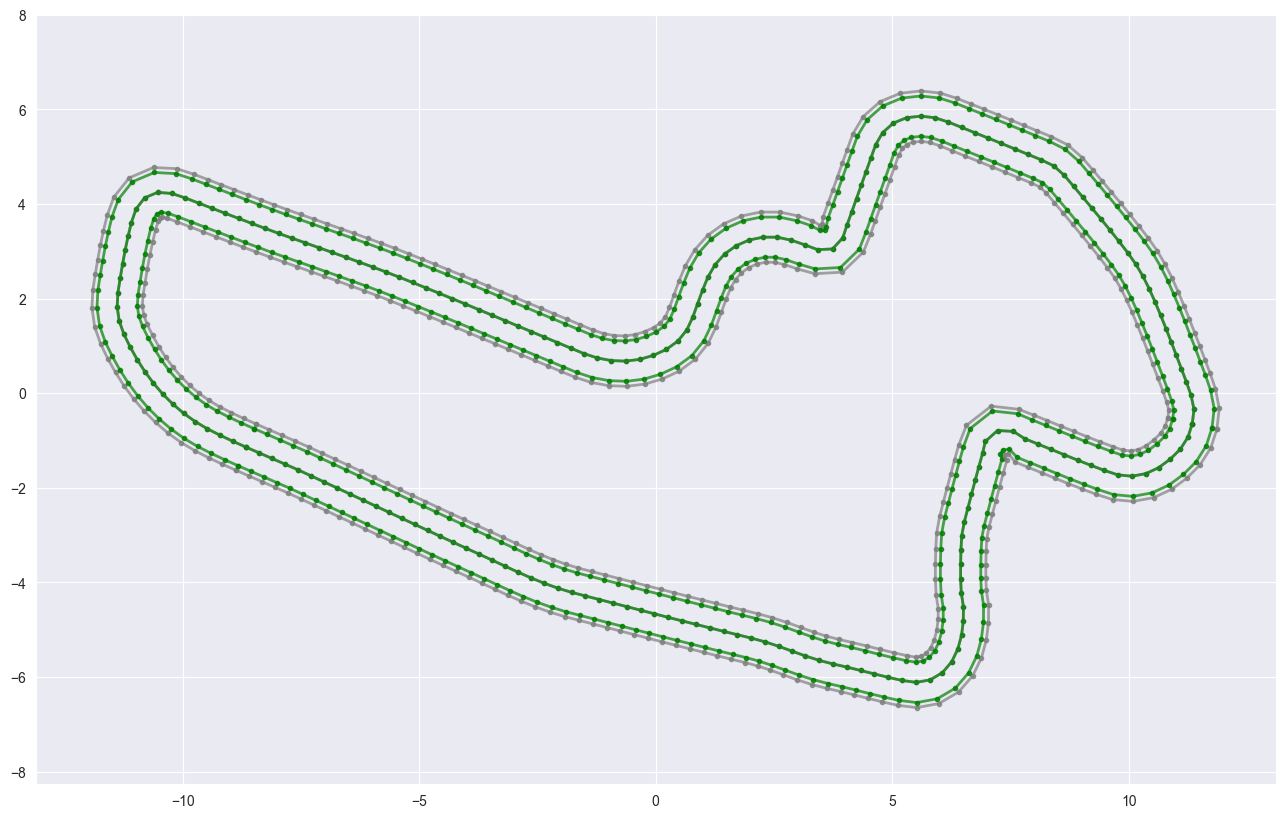

In [55]:
# Load and transform waypoints

def plot_track(ax, points, inner_points, outer_points, theme, orl=False):
    def plot_coords(ax, ob, theme=theme):
        x, y = ob.xy
        ax.plot(x, y, '.', alpha=0.8, color=theme, linewidth=1, zorder=1)

    def plot_line(ax, ob, theme=theme):
        x, y = ob.xy
        ax.plot(x, y, alpha=0.7, color=theme, linewidth=2, solid_capstyle='round', zorder=2)

    line = LineString(points)
    plot_coords(ax, line, theme if not orl else 'red')
    plot_line(ax, line, theme if not orl else 'red')

    line = LineString(inner_points)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(outer_points)
    plot_coords(ax, line)
    plot_line(ax, line)

# def-prefix: default values
def_waypoints = get_default_waypoints(base_dir=TRACKS_DIR, filename=TRACK_NAME)
def_center = def_waypoints[:,0:2]
def_inner = def_waypoints[:,2:4]
def_outer = def_waypoints[:,4:6]

# red-prefix: reduced values
red_inner, red_outer = get_reduced_waypoints(given_points=def_waypoints, reduce_by=opt_track_width_reduction_perc)

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111)
plt.axis('equal')
plot_track(ax, def_center, def_inner, def_outer, 'gray')
plot_track(ax, def_center, red_inner, red_outer, 'green')


## Calculate Optimized Race Line (ORL, orl)

In [44]:
# Number of times to iterate each new race line point
# keep this at 3-8 for best balance of performance and desired result
XI_ITERATIONS=8 # default 4

# Number of times to scan the entire race track to iterate
# 500 will get a good start, 1500 will be closer to optimal result
LINE_ITERATIONS=1000 # default 1000


In [45]:
def menger_curvature(point1, point2, point3):
    """Calculate the curvature using the Menger curvature formula."""
    vec21 = np.array(point2) - np.array(point1)
    vec23 = np.array(point2) - np.array(point3)
    norm21 = np.linalg.norm(vec21)
    norm23 = np.linalg.norm(vec23)

    if norm21 == 0 or norm23 == 0:
        return 0

    # Ensure the dot product is within the valid range for arccos
    dot_product = np.dot(vec21, vec23) / (norm21 * norm23)
    dot_product = np.clip(dot_product, -1.0, 1.0)

    theta = np.arccos(dot_product)
    curvature = 2 * np.sin(theta) / np.linalg.norm(np.array(point1) - np.array(point3))

    return curvature

def improve_race_line(old_line, inner_border, outer_border):
    '''Use gradient descent, inspired by K1999, to find the racing line'''
    # start with the center line
    new_line = copy.deepcopy(old_line)
    ls_inner_border = Polygon(inner_border)
    ls_outer_border = Polygon(outer_border)
    for i in range(0,len(new_line)):
        xi = new_line[i]
        npoints = len(new_line)
        prevprev = (i - 2 + npoints) % npoints
        prev = (i - 1 + npoints) % npoints
        nexxt = (i + 1 + npoints) % npoints
        nexxtnexxt = (i + 2 + npoints) % npoints
        #print("%d: %d %d %d %d %d" % (npoints, prevprev, prev, i, nexxt, nexxtnexxt))
        ci = menger_curvature(new_line[prev], xi, new_line[nexxt])
        c1 = menger_curvature(new_line[prevprev], new_line[prev], xi)
        c2 = menger_curvature(xi, new_line[nexxt], new_line[nexxtnexxt])
        target_ci = (c1 + c2) / 2
        #print("i %d ci %f target_ci %f c1 %f c2 %f" % (i, ci, target_ci, c1, c2))

        # Calculate prospective new track position, start at half-way (curvature zero)
        xi_bound1 = copy.deepcopy(xi)
        xi_bound2 = ((new_line[nexxt][0] + new_line[prev][0]) / 2.0, (new_line[nexxt][1] + new_line[prev][1]) / 2.0)
        p_xi = copy.deepcopy(xi)
        for j in range(0,XI_ITERATIONS):
            p_ci = menger_curvature(new_line[prev], p_xi, new_line[nexxt])
            #print("i: {} iter {} p_ci {} p_xi {} b1 {} b2 {}".format(i,j,p_ci,p_xi,xi_bound1, xi_bound2))
            if np.isclose(p_ci, target_ci):
                break
            if p_ci < target_ci:
                # too flat, shrinking track too much
                xi_bound2 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound1[0] + p_xi[0]) / 2.0, (xi_bound1[1] + p_xi[1]) / 2.0)
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound1 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
            else:
                # too curved, flatten it out
                xi_bound1 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound2[0] + p_xi[0]) / 2.0, (xi_bound2[1] + p_xi[1]) / 2.0)

                # If iteration pushes the point beyond the border of the track,
                # just abandon the refinement at this point.  As adjacent
                # points are adjusted within the track the point should gradually
                # make its way to a new position.  A better way would be to use
                # a projection of the point on the border as the new bound.  Later.
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound2 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
        new_xi = p_xi
        # New point which has mid-curvature of prev and next points but may be outside of track
        #print((new_line[i], new_xi))
        new_line[i] = new_xi
    return new_line

In [46]:
# Iterate over race line
race_line = copy.deepcopy(def_center[:-1])  # Use this for centerline being outer bound
for i in range(LINE_ITERATIONS):
    race_line = improve_race_line(race_line, red_inner, red_outer)  # Remove "_new" for entire track width
    if i % 20 == 0: print("Iteration %d" % i, end="\r", flush=True)

In [47]:
optimized_race_line = np.append(race_line, [race_line[0]], axis=0)

# These should be the same
print("These should be the same: ", (def_center.shape, optimized_race_line.shape))
print("Original centerline length: %0.2f" % LineString(def_center).length)
print("New race line length: %0.2f" % LineString(optimized_race_line).length)

These should be the same:  ((208, 2), (208, 2))
Original centerline length: 62.08
New race line length: 58.13


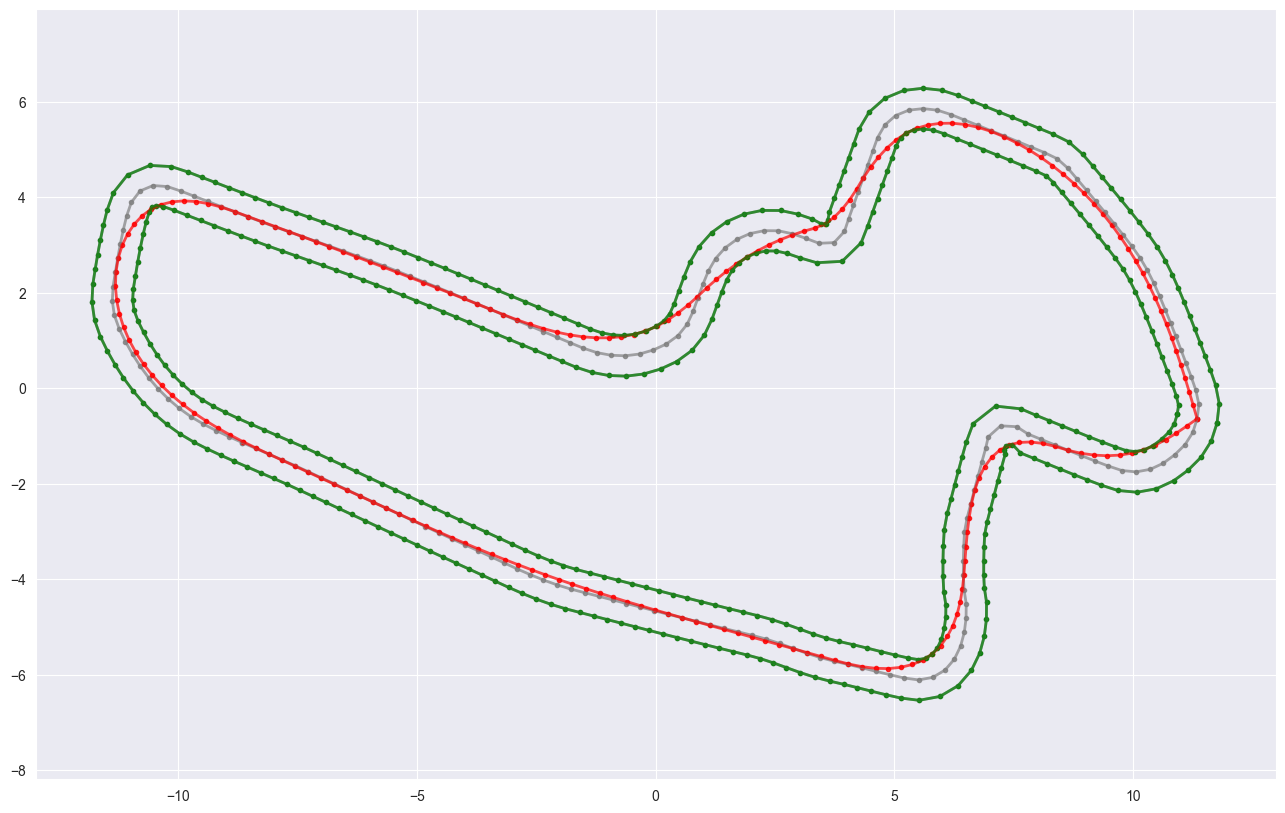

In [56]:
# Plot optimized race line
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111)
plt.axis('equal')
plot_track(ax, def_center, red_inner, red_outer, 'gray')
plot_track(ax, optimized_race_line, red_inner, red_outer, 'green', True)